In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/mikhail/anaconda3/envs/project/project_rs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/mikhail/anaconda3/envs/project/project_rs/submission1.csv
/home/mikhail/anaconda3/envs/project/project_rs/sample_submission.csv
/home/mikhail/anaconda3/envs/project/project_rs/Без названия.ipynb
/home/mikhail/anaconda3/envs/project/project_rs/baselinenotebook.ipynb
/home/mikhail/anaconda3/envs/project/project_rs/submission2.csv
/home/mikhail/anaconda3/envs/project/project_rs/test.csv
/home/mikhail/anaconda3/envs/project/project_rs/submission.csv
/home/mikhail/anaconda3/envs/project/project_rs/train.csv
/home/mikhail/anaconda3/envs/project/project_rs/.ipynb_checkpoints/baselinenotebook-checkpoint.ipynb
/home/mikhail/anaconda3/envs/project/project_rs/.ipynb_checkpoints/Без названия-checkpoint.ipynb


In [21]:
#Читаем файлы
train = pd.read_csv('/home/mikhail/anaconda3/envs/project/project_rs/train.csv')
test = pd.read_csv('/home/mikhail/anaconda3/envs/project/project_rs/test.csv')
submission = pd.read_csv('/home/mikhail/anaconda3/envs/project/project_rs/sample_submission.csv')

/home/mikhail/anaconda3/envs/project/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/mikhail/anaconda3/envs/project/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [142]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

### Preprocessing data

In [23]:
train.shape, train.isna().sum()

((857895, 14),
 overall                0
 verified               0
 reviewTime             0
 asin                   0
 reviewerName         176
 reviewText           279
 summary              170
 unixReviewTime         0
 vote              739155
 style             413489
 image             850753
 userid                 0
 itemid                 0
 rating                 0
 dtype: int64)

In [24]:
train.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [25]:
test.head()

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


In [26]:
#Создаем общую выюорку (train + test). Удаляем столбцы отсутствующие в test.
train['sample'] = 1
test['sample'] = 0
y_train = train['rating']
df = pd.concat([train.drop(['overall', 'reviewText', 'summary', 'rating'], axis = 1), test.drop(['Id'], axis = 1)], 
               axis = 0, ignore_index = True)

In [27]:
df

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,sample
0,True,"10 4, 2016",B01CPNIEQG,Heather,1475539200,NaN,NaN,NaN,102179,37138,1
1,True,"03 1, 2016",B006F63M8U,Linda Odom,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1
2,True,"06 26, 2016",B00112O8NG,DesertBlossom,1466899200,28,NaN,NaN,39495,5600,1
3,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,1378339200,NaN,NaN,NaN,72854,30249,1
4,True,"09 14, 2016",B000R7RN0G,Mike P.,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1
...,...,...,...,...,...,...,...,...,...,...,...
1143855,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,0
1143856,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,0
1143857,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,0
1143858,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,0


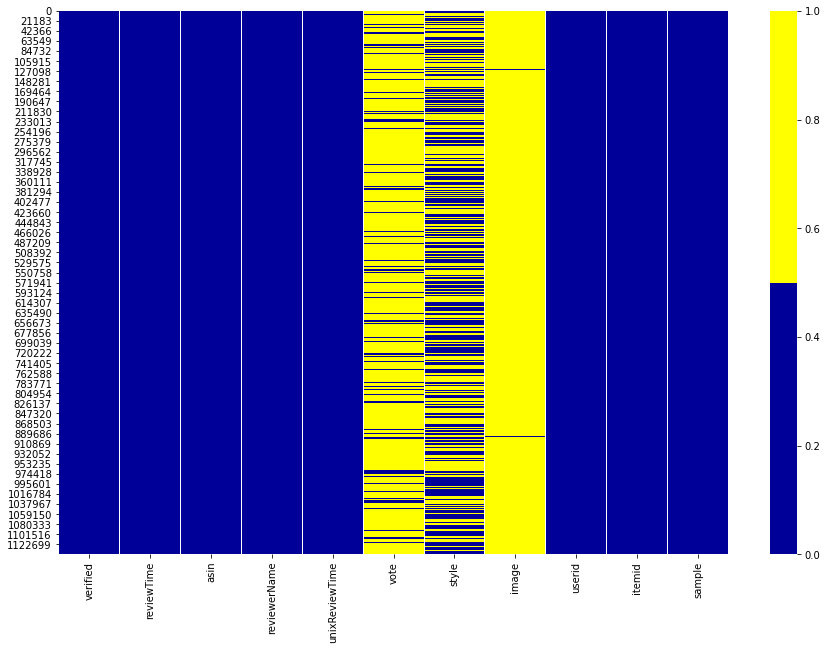

In [28]:
#Cмотрим на графике кол-во пропусков (желтый цвет)
fig= plt.figure(figsize=(15,10))
sns.heatmap(df.isnull(), cmap=sns.color_palette(['#000099', '#ffff00']))
plt.show()

Признаки vote, style, image имеют большое кол-во пропусков, таким образом не сыграют роль в обучении модели. Пары признаков: reviewTime, unixReviewTime; itemid, asin; reviewName, userid являются идентичными. Таким образом в датасете остается 4 значимых признака (verified, unixReviewTime, userid, itemid) и целевой rating.

In [136]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [137]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [34]:
def selection_of_hyperparameters(user_features, item_features):
    for num in [5, 10, 15, 20, 25, 30]:
        for rate in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]:
            model = LightFM(learning_rate=rate, loss='logistic',
                        no_components=NUM_COMPONENTS)
            model = model.fit(ratings_coo,user_features, item_features, epochs=num, 
                          num_threads=NUM_THREADS)
            preds = model.predict(test_data.userid.values,
                              test_data.itemid.values)
            print(f'При NUM_EPOCHS ={num} и learning_rate = {rate} ROC AUC = ', sklearn.metrics.roc_auc_score(test_data.rating,preds))

In [18]:
selection_of_hyperparameters(None, None)

При NUM_EPOCHS =5 и learning_rate = 0.01 ROC AUC =  0.6168872004418112
При NUM_EPOCHS =5 и learning_rate = 0.02 ROC AUC =  0.6243380844476099
При NUM_EPOCHS =5 и learning_rate = 0.05 ROC AUC =  0.6614277579785074
При NUM_EPOCHS =5 и learning_rate = 0.1 ROC AUC =  0.7092769359156184
При NUM_EPOCHS =5 и learning_rate = 0.2 ROC AUC =  0.7475415746247824
При NUM_EPOCHS =5 и learning_rate = 0.3 ROC AUC =  0.7550025039319042
При NUM_EPOCHS =5 и learning_rate = 0.5 ROC AUC =  0.7489769005934275
При NUM_EPOCHS =10 и learning_rate = 0.01 ROC AUC =  0.6242835155985195
При NUM_EPOCHS =10 и learning_rate = 0.02 ROC AUC =  0.6394186161291531
При NUM_EPOCHS =10 и learning_rate = 0.05 ROC AUC =  0.7024450274376175
При NUM_EPOCHS =10 и learning_rate = 0.1 ROC AUC =  0.7426601066420386
При NUM_EPOCHS =10 и learning_rate = 0.2 ROC AUC =  0.749412225693705
При NUM_EPOCHS =10 и learning_rate = 0.3 ROC AUC =  0.7453611079630547
При NUM_EPOCHS =10 и learning_rate = 0.5 ROC AUC =  0.7404507098799384
При NUM_

Наилучший результат При NUM_EPOCHS =5 и learning_rate = :0.3 ROC AUC =  0.7549646550312343

In [138]:
NUM_THREADS = 8 #число потоков
NUM_COMPONENTS = 35 #число параметров вектора 
NUM_EPOCHS = 5 #число эпох обучения

model = LightFM(learning_rate=0.33, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [139]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [140]:
test_data.userid.values

array([22375, 80565, 55565, ..., 81334, 84738, 32096])

In [141]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7551798547351114

In [143]:
with open('model.pickle', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

### Улучшение модели

In [40]:
def st(x):
    try:
        return x[1:-1].replace(' ', '').split(',')
    except:
        return 0

In [41]:
train['styles'] = train['style'].apply(st)

In [66]:
class New_features():
    
    def size(x):
        if x != 0:
            for item in x:
                if 'Size' in item:
                    return item
            
    def flavor(x):
        if x != 0:
            for item in x:
                if 'Flavor' in item:
                    return item
                
    def package_type(x):
        if x != 0:
            for item in x:
                if 'PackageType' in item:
                    return item
            
    def package_quantity(x):
        if x != 0:
            for item in x:
                if 'PackageQuantity' in item:
                    return item
            
    def color(x):
        if x != 0:
            for item in x:
                if 'Color' in item:
                    return item
                
    def format_(x):
        if x != 0:
            for item in x:
                if 'Format' in item:
                    return item
        
    def style_name(x):
        if x != 0:
            for item in x:
                if 'StyleName' in item:
                    return item

In [53]:
train['size'] = train['styles'].apply(New_features.size)

train['flavor'] = train.styles.apply(New_features.flavor)

train['PackageType'] = train.styles.apply(New_features.package_type)

train['PackageQuantity'] = train.styles.apply(New_features.package_quantity)

train['Color'] = train.styles.apply(New_features.color)

train['Format'] = train.styles.apply(New_features.format_)

train['StyleName'] = train.styles.apply(New_features.style_name)

dict_size = dict(zip(train['size'].value_counts()[0:500].index, [x for x in range(1,501)]))

dict_flavor = dict(zip(train['flavor'].value_counts()[0:500].index, [x for x in range(501,1001)]))

dict_PackageType = dict(zip(train['PackageType'].value_counts().index, [x for x in range(1001, 1005)]))

dict_PackageQuantity = dict(zip(train['PackageQuantity'].value_counts().index, [x for x in range(1005, 1027)]))

dict_Color = dict(zip(train['Color'].value_counts()[0:50].index, [x for x in range(1027, 1077)]))

dict_Format = dict(zip(train['Format'].value_counts()[0:6].index, [x for x in range(1077, 1083)]))

dict_StyleName = dict(zip(train['StyleName'].value_counts()[0:10].index, [x for x in range(1083, 1093)]))

dict_total = {**dict_size, **dict_flavor,**dict_PackageType,**dict_PackageQuantity,**dict_Color,**dict_Format,**dict_StyleName}

In [122]:
dict_total["'StyleName:':'ACLASS'"]

1092

In [121]:
dict_StyleName

{"'StyleName:':'0'": 1083,
 "'StyleName:':'White'": 1084,
 "'StyleName:':'Spaghetti'": 1085,
 "'StyleName:':'BrightWhite'": 1086,
 "'StyleName:':'Penne'": 1087,
 "'StyleName:':'WiltonColorRightPerformanceColorSystem'": 1088,
 "'StyleName:':'Pouch'": 1089,
 "'StyleName:':'SinglesSizeVariety'": 1090,
 "'StyleName:':'FunSize'": 1091,
 "'StyleName:':'ACLASS'": 1092}

In [80]:
df = pd.DataFrame([], columns=['itemid', 'tags'])

In [82]:
for i in range(0, len(train)):
    for col in ['size','flavor','PackageType','PackageQuantity','Color','Format','StyleName']:
        x = train.loc[i][col]
        if x != None and x in dict_total:
            df.loc[len(df)] = [train.loc[i]['itemid'], dict_total[x]]
    print(i/len(train)*100, end='\r')

In [83]:
with open('df_features.pickle', 'wb') as file:
    pickle.dump(df, file, protocol=pickle.HIGHEST_PROTOCOL)

In [129]:
feature = sparse.coo_matrix(([1]*len(df),(df.itemid, df.tags)))
feature.shape

(41319, 1093)

In [131]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [134]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
ratings_coo.shape

(127496, 41320)

In [135]:
NUM_THREADS = 8 #число потоков
NUM_COMPONENTS = 35 #число параметров вектора 
NUM_EPOCHS = 5 #число эпох обучения

model = LightFM(learning_rate=0.33, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS, item_features = feature)

Exception: Number of item feature rows does not equal the number of items

In [ ]:
#Надо пофиксить.

### Submission

In [144]:
with open('model.pickle', 'rb') as file:
    model = pickle.load(file)

In [145]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [146]:
preds.min(), preds.max()

(-18.120452880859375, 18.808809280395508)

In [147]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [148]:
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [149]:
submission['rating']= normalized_preds

In [150]:
submission

,Id,rating
0,0,0.559034
1,1,0.545435
2,2,0.506322
3,3,0.496739
4,4,0.508745
...,...,...
285960,285960,0.554123
285961,285961,0.396806
285962,285962,0.502390
285963,285963,0.557439


In [112]:
submission.to_csv('submission2.csv', index = False)

In [151]:
# Достаём эбмеддинги

item_biases, item_embeddings = model.get_item_representations()

In [153]:
import nmslib
 
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [154]:
#Вспомогательная функция для поиска по графу
def nearest_books_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [172]:
train.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,rating,sample,styles,size,flavor,PackageType,PackageQuantity,Color,Format,StyleName
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,...,1.0,1,0,None,None,None,None,None,None,None
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},...,1.0,1,['Size:':'60-0.73ozEnvelopes'],'Size:':'60-0.73ozEnvelopes',None,None,None,None,None,None
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,...,1.0,1,0,None,None,None,None,None,None,None
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,...,1.0,1,0,None,None,None,None,None,None,None
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},...,1.0,1,['Flavor:':'Jalapeo'],None,'Flavor:':'Jalapeo',None,None,None,None,None


In [160]:
train.loc[4].flavor

"'Flavor:':'Jalapeo'"

In [165]:
train[train.flavor.str.find('Jalapeo')>=0]['itemid'].head(2)

4         4349
200935    4349
Name: itemid, dtype: int64

In [166]:
nbm = nearest_books_nms(4349,nms_idx)[0]

In [169]:
train[train.itemid.isin(nbm)][:4]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,rating,sample,styles,size,flavor,PackageType,PackageQuantity,Color,Format,StyleName
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},...,1.0,1,['Flavor:':'Jalapeo'],None,'Flavor:':'Jalapeo',None,None,None,None,None
202,5.0,True,"10 6, 2016",B00HQDVRU6,Agatha Morazzani,Good,Good,1475712000,NaN,NaN,...,1.0,1,0,None,None,None,None,None,None,None
529,5.0,True,"06 18, 2015",B0058AMYTC,Rooster,These are delicious crunchy potato chips. It d...,Yum!,1434585600,NaN,"{'Size:': ' 5 Ounce (Pack of 15)', 'Flavor:': ...",...,1.0,1,"['Size:':'5Ounce(Packof15)', 'Flavor:':'Unsalt...",'Size:':'5Ounce(Packof15)','Flavor:':'Unsalted',None,None,None,None,None
2693,4.0,True,"03 17, 2017",B00HQDVRU6,Katrina,"I didn't expect to like these so much, but my ...",Surprising flavor,1489708800,NaN,NaN,...,1.0,1,0,None,None,None,None,None,None,None


In [170]:
with open('item_embeddings.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
train[train.itemid == 4]['asin'].loc[train[train.itemid == 4]['asin'].index[0]]